# Building Support Vector Machine from Scratch

Here, we import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

below, we apply a sklearn package to generate our data.

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=3)
np.place(y, y==0, -1)

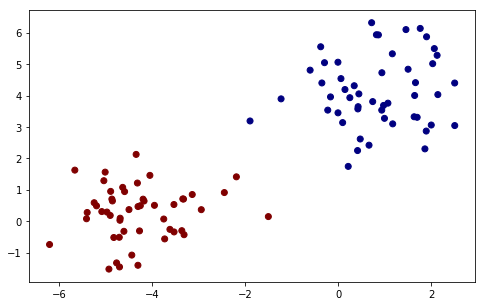

In [3]:
plt.figure(figsize = (8,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'jet')

In [4]:
pd.concat([pd.DataFrame(X, columns = ["$x_1$", "$x_2$"]), pd.DataFrame(y, columns = ["$y$"])], axis=1).head(5)

,$x_1$,$x_2$,$y$
0,-3.755938,0.067538,1
1,-2.948434,0.365538,1
2,-3.367091,-0.303440,1
3,1.890244,2.869420,-1
4,-4.770407,-1.330004,1


---

## Representation: Support Vector Machine

The goal of a Support Vector Machine:
>To find the optimal separating hyperplane which maximizes the margin of the training data

![Machine Learning Algorithms](Figures/hyp.png)

This is an intuitive example of a hyperplane in 2-dimensions. This definition can be generalized and expanded to any number of dimensions!
* In 1-D, a hyperplane is a point
* In 2-D, a hyperplane is a line
* In 3-D, a hyperplane is a plane
* In 4-D+, it is simply referred to as a hyperplane.

### How do we find the optimal hyperplane?
We choose the hyperplane that maximizes the margin between the two classes, because it generalizes better to unseen observations (makes better predictions).
![Machine Learning Algorithms](Figures/opt_max_margin.png)

If we define the equation of our line to be $$y=mx+b$$ per usual, then this translates to finding the optimal $m$ and $b$.

### Understanding the definition of a Hyperplane:
As we've seen previously, the separating hyperplane that we keep referring to (in 2-d) is just a line

$$y=mx+b$$
With a bit of algebraic manipulation, we get:

>\begin{align*}
y&=mx+b\\
-b-mx+y&=0
\end{align*}

Using this new notation, the equation of a line is:

$$w_0+w_1x_1+w_2x_2=0$$

and more generally, for $p$ dimensions, the equation for a hyperplane is:

$$w_0+w_1x_1+w_2x_2+\dots+w_px_p=0$$

Note: In our crash data, we use over 14 variables, so the equation for the separating hyperplane will look like this:

$$w_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5 + w_6x_6 + w_7x_7 + w_8x_8 + w_9x_9 + w_{10}x_{10} + w_{11}x_{11} + w_{12}x_{12} + w_{13}x_{13} + w_{14}x_{14}=0$$

For the human, this is incredibly difficult to work work, for the machine, it is simple. Additionally, this is also the dot product of $\overrightarrow{w}$ and $\overrightarrow{x}$.

In [5]:
# Do not run this more than once, as it will add more intercept terms
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [6]:
X = add_intercept(X)

In [7]:
pd.DataFrame(X[:5,:], columns = ["$x_0$", "$x_1$", "$x_2$"])

,$x_0$,$x_1$,$x_2$
0,1.0,-3.755938,0.067538
1,1.0,-2.948434,0.365538
2,1.0,-3.367091,-0.303440
3,1.0,1.890244,2.869420
4,1.0,-4.770407,-1.330004


---

## Evaluation: Hinge Loss Function

#### Quick refresher on dot product
Given that you have two vectors, 

$$\overrightarrow{w}=\left[\begin{matrix}
w_1\\
w_1\\
\end{matrix}
\right],\ 
\overrightarrow{x} = \left[\begin{matrix}
x_1\\
x_2\\
\end{matrix}
\right]
$$

The dot product (also referred to as inner product) is:

$$\overrightarrow{w} \cdot \overrightarrow{x} = w_1x_1+w_2x_2$$

*note that this is a scalar value

#### Dot product as distance from hyperplane

It turns out that, when we take the dot product of our weights vector $\overrightarrow{w}$ and a single datapoint $\overrightarrow{x^{(i)}}$, the resulting number that we get can be thought of as how far away that  data point is from the hyperplane.

* Note that in this context we use "distance" loosely
* Alexandre Kowalczyk has an [great blog post](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-2/) detailing this
* Prof. Andrew Ng provides us with [rigorous mathematical interpretation](http://cs229.stanford.edu/notes/cs229-notes3.pdf) as well.
* I also took a shot at proving this mathematically, and you can view my explanation [here](https://github.com/collinprather/Big-Data-Ignite-2018/blob/master/Support_Vector_Machines/dot_product_as_dist_from_hyp.ipynb)

#### The Hinge Loss Function is defined as:

$$Loss\ \left(\overrightarrow{w}, \overrightarrow{x^{(i)}}, y^{(i)}\right) = \left[ 1 - y^{(i)} \cdot \left(\overrightarrow{w} \cdot \overrightarrow{x^{(i)}} \right)\right]_+$$

Let's break it down:

* Inputs:
    * $\overrightarrow{w}$ is a vector of weights (coefficients) in the linear equation.
    * $\overrightarrow{x^{(i)}}$ is a vector representing a single datapoint (the $i^{th}$ datapoint), or a single row in our dataset
    * $y^{(i)}$ is the label associated with the datapoint (which is either 1 or -1)
    

* Output:
    * a scalar value representing a penalty for how wrong our prediction was. The greater the penatly, the worse our estimated weights were in classifying the data.
    

* For the sake of this example, let's assume that each data point, whether positive or negative, whether correctly or incorrectly classified, is 3 units away from the hyperplane.

<p align="center">
  <img src="Figures/hinge_loss_breakdown.png" >
</p>

In [8]:
def hinge_loss(X_i, y_i, weights):
    penalty = 1 - y_i * np.dot(weights.T, X_i)
    if penalty < 0:
        penalty = 0
    return penalty

In [12]:
# quick test of hinge loss function
# first run it with w = [2,-3,-2]
# then run it with w = [50, -3, 2]
hinge_loss(X_i = X[5,:], y_i = y[5], weights = np.array([2, -3, -2]))

0

#### Hinge Loss with regularization term:

These two exmaples below exemplify how one outlier can skew the separating hyperplane, and thus the need for the regularization term.

![Skewed hyp](Figures/skewed_hyp.png)

* Scott Fortmann-Roe provides a [fantastic, interactive explanation for the bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html) and statistical techniques decrease variance, while keeping bias fixed.
* Here's [a great stack exchange explanation](https://datascience.stackexchange.com/questions/4943/intuition-for-the-regularization-parameter-in-svm) for the reasoning behind the regularization term in the Hinge Loss function.


$$Loss\ \left(\overrightarrow{w}, \overrightarrow{x^{(i)}}, y^{(i)}\right) = \left[ 1 - y^{(i)} \cdot \left(\overrightarrow{w} \cdot \overrightarrow{x^{(i)}} \right)\right]_+ + \lambda\sum_{i}^{n}\ w_i^2$$

* As $\lambda$ gets smaller and smaller, the margin grows wider and wider (often to the point of misclassifying datapoints)
* As $\lambda$ gets larger and larger, the margin grows thinner and thinner (often to the point of perfectly classifying datapoints)

![Skewed hyp](Figures/lambda_comparisons.png)

---

## Optimization: Stochastic Gradient Descent

#### Resources:
* [super helpful explanations of all types of gradient descent](https://am207.github.io/2017/wiki/gradientdescent.html#stochastic-gradient-descent)
* Stanford's [interactive web demo](http://vision.stanford.edu/teaching/cs231n-demos/linear-classify/) that allows us to tinker with multi-class SVM gradient descent
* Awesome [visualizations of Gradient Descent](https://jed-ai.github.io/py1_gd_animation/) (and some mathematical representations)
* Helpful explanation of [how to calculcate the gradients](https://stats.stackexchange.com/questions/4608/gradient-of-hinge-loss) in Hinge Loss.

<p align="center">
  <img src="Figures/gradient_descent.png" >
</p>

#### Calculating the Partial Derivatives
* [Best resource online](http://mccormickml.com/2014/03/04/gradient-descent-derivation/) for gradient descent derivation

Here is our objective function (function to optimize):

$$Loss\ \left(\overrightarrow{w}, \overrightarrow{x^{(i)}}, y^{(i)}\right) = \left[ 1 - y^{(i)} \cdot \left(\overrightarrow{w} \cdot \overrightarrow{x^{(i)}} \right)\right]_+ + \lambda\sum_{i}^{n}\ w_i^2$$

We will calulate the partial derivative of the loss term and regularization term separately:

##### Derivative of Loss term:

$$\frac{\delta}{\delta w_j}\ \  \left[ 1 - y^{(i)} \cdot \left(\overrightarrow{w} \cdot \overrightarrow{x^{(i)}} \right)\right]_+= \begin{cases}
0&y^{(i)} \cdot \left(\overrightarrow{w} \cdot \overrightarrow{x^{(i)}} \right) \geq 1\\
-y^{(i)}x^{(i)}_{j}&\ \text{otherwise}
\end{cases}$$

##### Derivative of Regularization term:

$$\frac{\delta}{\delta w_j}\ \ \lambda\sum_{i}^{n}\ w_i^2 = 2\lambda w_j$$

#### Update Rules

##### Correct Classification:

$$\overrightarrow{w} := \overrightarrow{w} - \alpha(2\lambda\overrightarrow{w})$$

##### Incorrect Classification:

$$\overrightarrow{w} := \overrightarrow{w} - \alpha \left(\left(-y^{(i)}x^{(i)}_{j}\right) + 2\lambda\overrightarrow{w}\right)$$

In [13]:
learning_rate = 1
num_iters = 100
# lambda = 1/iteration

def Stochastic_Gradient_Descent(X, y, learning_rate, num_iters):
    weights = np.zeros(len(X[0]))
    for iteration in range(1, num_iters):
        for row in range(len(X)):
            penalty = hinge_loss(X[row], y[row], weights)
            if penalty == 0:
                weights = weights - learning_rate * ((2  * (1/iteration) * weights))
            else:
                weights = weights - learning_rate * ((-y[row] * X[row]) + (2  * (1/iteration) * weights))
    return weights

In [14]:
weights = Stochastic_Gradient_Descent(X = X, y=y, learning_rate=1, num_iters = 500)

In [15]:
weights

array([ 0.00466211, -3.89873489, -3.00597691])

In [16]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], weights))
total_loss = np.sum(loss)
total_loss

0

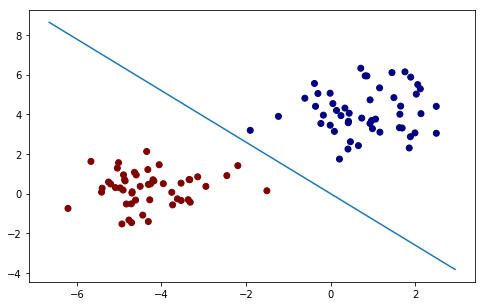

In [17]:
# it works, we've found the perfectly separating hyperplane!
plt.figure(figsize = (8,5))
plt.scatter(X[:,1], X[:,2], c=y, cmap = 'jet')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xx, (-weights[1]/weights[2]) * xx - (weights[0]/weights[2]))

---

---

---

# Applying SVM to GR Crash Data

* Instead of their traditional SVM, I could use the [Stochastic Gradient Descent Classifier](http://scikit-learn.org/stable/modules/sgd.html)

```python
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", alpha=0.01, penalty="l2", fit_intercept=True)
clf.fit(X, y)
```

Note that `SVC(kernel="linear")` is equivalent to `SGDClassifier(loss="hinge")` as [scikit-learn's documentation indicates](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py)

In [18]:
X_cols = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'HOUR_X', 'HOUR_Y',
          'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M', 'DRIVER1SEX_U',
          'HITANDRUN_Yes', 'MOTORCYCLE_Yes',
          'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick']
y_cols = 'D1DRINKIN_Yes'

In [19]:
#crash_data = pd.read_csv('Data/Crash_data_prepared.csv')
data_url = "https://raw.githubusercontent.com/collinprather/Big-Data-Ignite-2018/master/Data/Crash_data_prepared.csv"
crash_data = pd.read_csv(data_url)
X = crash_data.loc[:, X_cols]
y = crash_data.loc[:, y_cols]

In [20]:
crash_data.head()

,X,Y,DRIVER1AGE,NUMOFINJ,HOUR_X,HOUR_Y,CRASHSEVER_Fatal,CRASHSEVER_Injury,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_Yes,HITANDRUN_Yes,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1DRINKIN_Yes,SPEEDLIMIT_BINS_25<speed<45,SPEEDLIMIT_BINS_45<speed<65,SPEEDLIMIT_BINS_65<speed
0,0.406318,-0.996140,1.685157,-0.416816,-0.258819,-9.659258e-01,0,0,0,0,0,1,0,1,0,0,1,0,0
1,0.411006,-0.996237,-0.269018,-0.416816,-1.000000,-1.836970e-16,0,0,1,0,0,1,0,0,0,0,1,0,0
2,0.413936,-0.996298,-0.836360,-0.416816,0.866025,-5.000000e-01,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0.416866,-0.996358,-0.332056,-0.416816,-0.866025,-5.000000e-01,0,0,1,0,0,1,0,1,0,0,1,0,0
4,0.416866,-0.996358,0.550474,-0.416816,-0.707107,-7.071068e-01,0,0,1,0,0,0,0,1,0,0,1,0,0


## Statistical Re-sampling
Since the recall was still very low after training our SVM, we will use a statistical re-sampling technique designed for dealing with imbalanced classes, like ours. We'll be using some tools from the [imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)

* `Recall` is our metric of choice. [this article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) provides a great explanation for why
    * In our instance, we're okay with incorectly guessing that there was alcohol involved with some car crashes, if it means predicting all the instances when there was alcohol involved
    * Generally speaking, when dealing with an imbalanced dataset, oversampling is a good technique to increase recall
* [this](https://beckernick.github.io/oversampling-modeling/) is a great article on the right way to oversmple.

In [21]:
#!pip install -U imbalanced-learn        # only run this in colab.research.google.com
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=742)

In [23]:
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

In [24]:
print("From the training data, the number of observations from each class is as follows:", sorted(Counter(y_train).items()), "\n")
print("From the oversampled training data, the number of observations from each class is as follows:", sorted(Counter(y_train_resampled).items()), "\n")

From the training data, the number of observations from each class is as follows: [(0, 52717), (1, 2015)] 

From the oversampled training data, the number of observations from each class is as follows: [(0, 52717), (1, 52717)] 



In [25]:
clf = SVC(kernel='linear')
clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.91      0.95     17543
          1       0.30      0.94      0.46       702

avg / total       0.97      0.91      0.93     18245



In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)
print('\n', confusion_matrix(y_test, y_pred))

True negatives: 16032
True positives: 657
False negatives: 45
False Positives: 1511

 [[16032  1511]
 [   45   657]]


In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.06  0.94]]


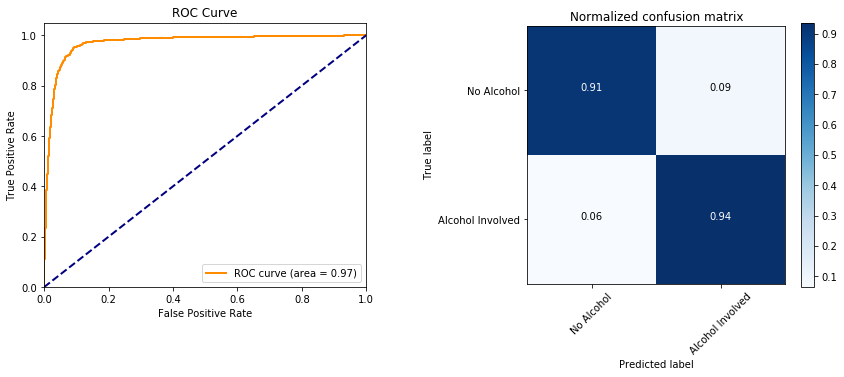

In [29]:
# define figure and add subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
lw=2
ax1.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=['No Alcohol', 'Alcohol Involved'], normalize=True,
                      title='Normalized confusion matrix')

# adjust spacing
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.5, hspace=None)